In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm import tqdm
import xgboost as xgb

# 1. 读取数据
df = pd.read_excel(r"D:\ML-3DPrinting-Project\data\7.7\2_regression_original.xlsx")

# 2. 删除不需要的列
#drop_cols = ['article']
#df = df.drop(columns=drop_cols)

# 3. 丢弃高缺失列 & 目标缺失行
df = df.dropna(axis=1, thresh=len(df)*0.5)
target_col = "printing_temp"
df = df.dropna(subset=[target_col]).reset_index(drop=True)

# 4.统计各列缺失值
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("\n各列缺失值统计：")
print(missing_counts[missing_counts > 0])

# 5. 查看维度
print(f"DataFrame 维度: {df.shape}")




各列缺失值统计：
nozzle_diameter    153
printing_speed     109
extrusion_speed     89
extrusion_temp      14
extruder_type       12
filament_aspect     10
platform_temp        8
dtype: int64
DataFrame 维度: (1172, 346)


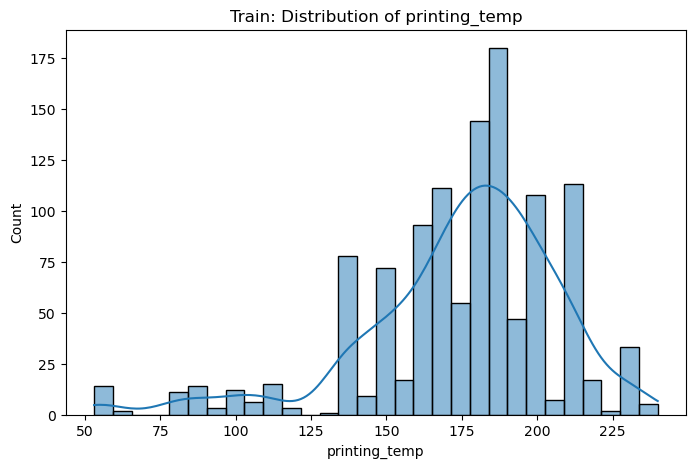

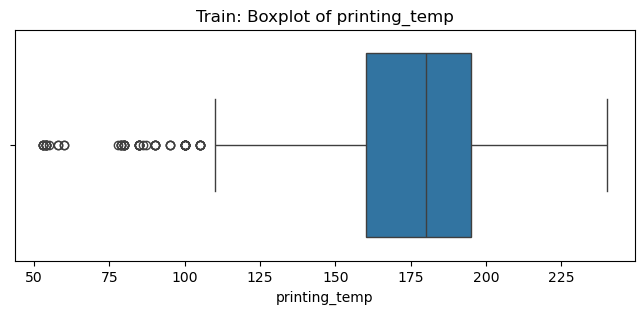

=== Target Descriptive Statistics ===
count    1172.000000
mean      174.903584
std        32.783990
min        53.000000
25%       160.000000
50%       180.000000
75%       195.000000
max       240.000000
Name: printing_temp, dtype: float64 

Skewness: -1.193
Kurtosis: 2.133


In [2]:
# 1. 划分 X, y
X = df.drop(columns=[target_col])
y = df[target_col]


# 2. 标签分布可视化 & 统计
plt.figure(figsize=(8,5))
sns.histplot(y, bins=30, kde=True)
plt.title(f"Train: Distribution of {target_col}")
plt.show()

plt.figure(figsize=(8,3))
sns.boxplot(x=y)
plt.title(f"Train: Boxplot of {target_col}")
plt.show()

print("=== Target Descriptive Statistics ===")
print(y.describe(), "\n")
print(f"Skewness: {skew(y):.3f}")
print(f"Kurtosis: {kurtosis(y):.3f}")



100%|████████████████████████████████████████████████████████████████████████████████| 342/342 [00:05<00:00, 68.20it/s]

已成功填补以下特征缺失: ['extrusion_temp', 'extrusion_speed', 'printing_speed', 'platform_temp', 'nozzle_diameter']
[0]	train-rmse:30.99677	eval-rmse:29.82758
[1]	train-rmse:29.19344	eval-rmse:28.31392
[2]	train-rmse:27.33134	eval-rmse:26.71987
[3]	train-rmse:25.78610	eval-rmse:25.36897


[4]	train-rmse:24.54062	eval-rmse:24.17394
[5]	train-rmse:23.17872	eval-rmse:22.89703
[6]	train-rmse:22.47438	eval-rmse:22.19885
[7]	train-rmse:21.79283	eval-rmse:21.63024
[8]	train-rmse:21.12514	eval-rmse:21.00444
[9]	train-rmse:20.04547	eval-rmse:20.01812
[10]	train-rmse:19.05873	eval-rmse:19.22484
[11]	train-rmse:18.20285	eval-rmse:18.57403
[12]	train-rmse:17.52731	eval-rmse:18.03646
[13]	train-rmse:16.75574	eval-rmse:17.47073
[14]	train-rmse:16.08518	eval-rmse:17.08810
[15]	train-rmse:15.40135	eval-rmse:16.51104
[16]	train-rmse:15.03833	eval-rmse:16.23012
[17]	train-rmse:14.54623	eval-rmse:15.86122
[18]	train-rmse:14.11114	eval-rmse:15.54292
[19]	train-rmse:13.71465	eval-rmse:15.31309
[20]	train-rmse:13.42775	eval-rmse:15.13978
[21]	train-rmse:13.08134	eval-rmse:15.00723
[22]	train-rmse:12.74870	eval-rmse:14.82503
[23]	train-rmse:12.46992	eval-rmse:14.63971
[24]	train-rmse:12.24181	eval-rmse:14.52860
[25]	train-rmse:12.06150	eval-rmse:14.43230
[26]	train-rmse:11.90818	eval-rmse:14.

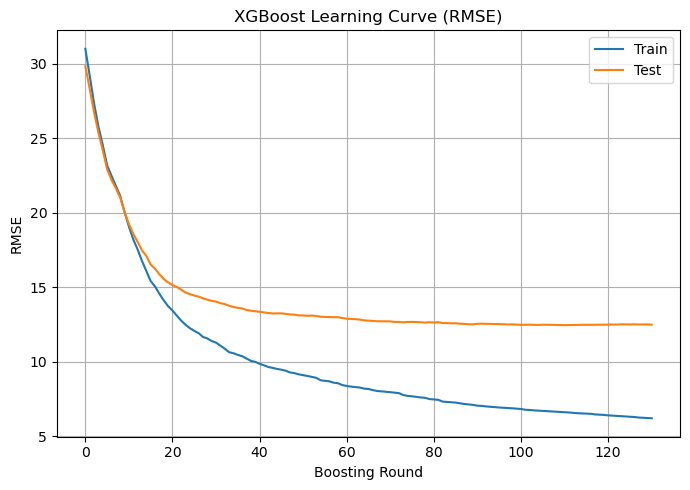

R² = 0.8447, RMSE = 12.4782, MAE = 8.3227


In [3]:

# === Step 2: 数据集划分（在任何编码、标准化之前）===
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Step 3: 添加缺失标志列（数值列）===
def add_missing_flags(X_raw):
    num_cols = X_raw.select_dtypes(include=['float64', 'int64']).columns
    missing_flags = pd.DataFrame(index=X_raw.index)
    for col in num_cols:
        if X_raw[col].isna().sum() > 0:
            missing_flags[f'{col}_was_missing'] = X_raw[col].isna().astype(int)
    return pd.concat([X_raw, missing_flags], axis=1)

X_train_flagged = add_missing_flags(X_train_raw)
X_test_flagged = add_missing_flags(X_test_raw)

# === Step 4: 类别填补 + One-Hot 编码 ===
cat_cols = X_train_flagged.select_dtypes(include=['object', 'category']).columns
X_train_flagged[cat_cols] = X_train_flagged[cat_cols].fillna("missing")
X_test_flagged[cat_cols] = X_test_flagged[cat_cols].fillna("missing")

X_train_encoded = pd.get_dummies(X_train_flagged, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_flagged, drop_first=True)

# 对齐测试集列（避免缺列）
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
cols = X_train_encoded.columns  # 记录列名用于 SHAP
# === Step 5: 标准化 ===
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded), columns=X_train_encoded.columns, index=X_train_encoded.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test_encoded.columns, index=X_test_encoded.index)

# === Step 6: 自监督 MLP 填补缺失值 ===
X_train_filled = X_train_scaled.copy()
X_test_filled = X_test_scaled.copy()
X_train_original = X_train_raw.copy()

num_cols = X_train_raw.select_dtypes(include=['float64', 'int64']).columns
filled_features = []

for col in tqdm(num_cols):
    if X_train_original[col].isna().sum() == 0:
        continue

    mask_train = X_train_original[col].isna()
    not_missing_mask = ~mask_train

    valid_cols = [c for c in X_train_scaled.columns if c != col and not X_train_scaled[c].isna().any()]
    if not valid_cols:
        continue

    X_train_feat = X_train_scaled.loc[not_missing_mask, valid_cols]
    y_train_feat = X_train_scaled.loc[not_missing_mask, col]

    model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
    model.fit(X_train_feat, y_train_feat)

    # 填补训练集
    X_missing_feat_train = X_train_scaled.loc[mask_train, valid_cols]
    X_train_filled.loc[mask_train, col] = model.predict(X_missing_feat_train)

    # 填补测试集（注意：使用 train 模型）
    mask_test = X_test_raw[col].isna() if col in X_test_raw.columns else None
    if mask_test is not None and mask_test.any():
        X_missing_feat_test = X_test_scaled.loc[mask_test, valid_cols]
        X_test_filled.loc[mask_test, col] = model.predict(X_missing_feat_test)

    filled_features.append(col)

print(f"已成功填补以下特征缺失: {filled_features}")

# === Step 7: 使用 XGBoost 回归建模 ===
dtrain = xgb.DMatrix(X_train_filled, label=y_train)
dtest = xgb.DMatrix(X_test_filled, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

evals = [(dtrain, 'train'), (dtest, 'eval')]
# 定义一个空字典来接收评估结果
results_dict = {}

# 训练 XGBoost 模型并保存每一轮的评估结果
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    evals_result=results_dict,
    verbose_eval=True
)

# 可视化 learning curve
results = results_dict


plt.figure(figsize=(7,5))
plt.plot(results['train']['rmse'], label='Train')
plt.plot(results['eval']['rmse'], label='Test')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost Learning Curve (RMSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

y_pred = model.predict(dtest)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R² = {r2:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}")


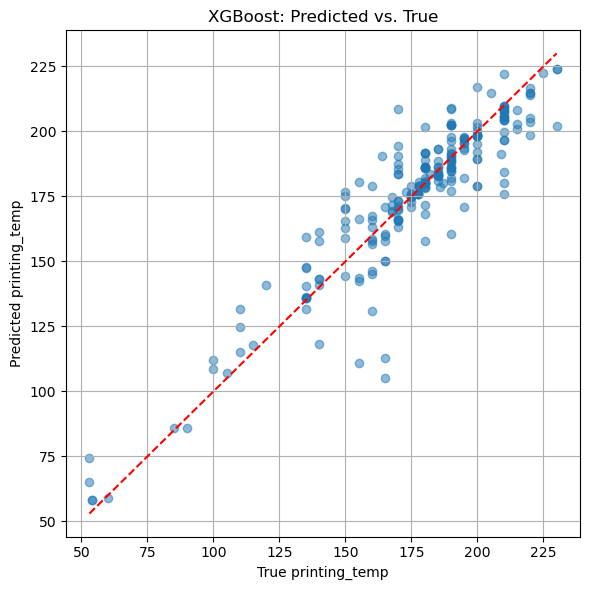

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True printing_temp")
plt.ylabel("Predicted printing_temp")
plt.title("XGBoost: Predicted vs. True")
plt.grid(True)
plt.tight_layout()
plt.show()


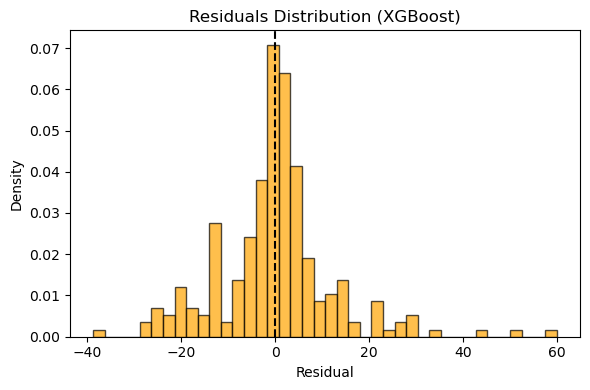

In [5]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, color='orange', edgecolor='black', alpha=0.7, density=True)
plt.title("Residuals Distribution (XGBoost)")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


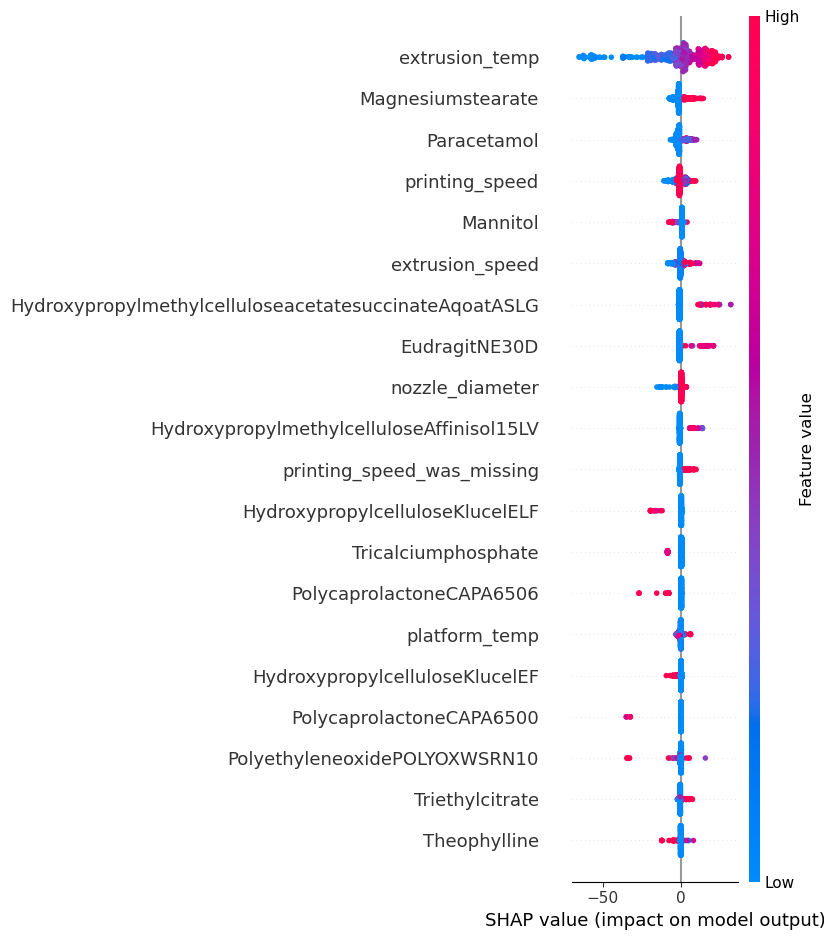

In [6]:
import shap
# 11. SHAP 可视化
shap.initjs()
explainer = shap.TreeExplainer(model)
# 转为 numpy array 形式（和训练模型一致）
shap_values = explainer.shap_values(X_train_filled.values)


shap.summary_plot(shap_values, X_train_filled, feature_names=cols)


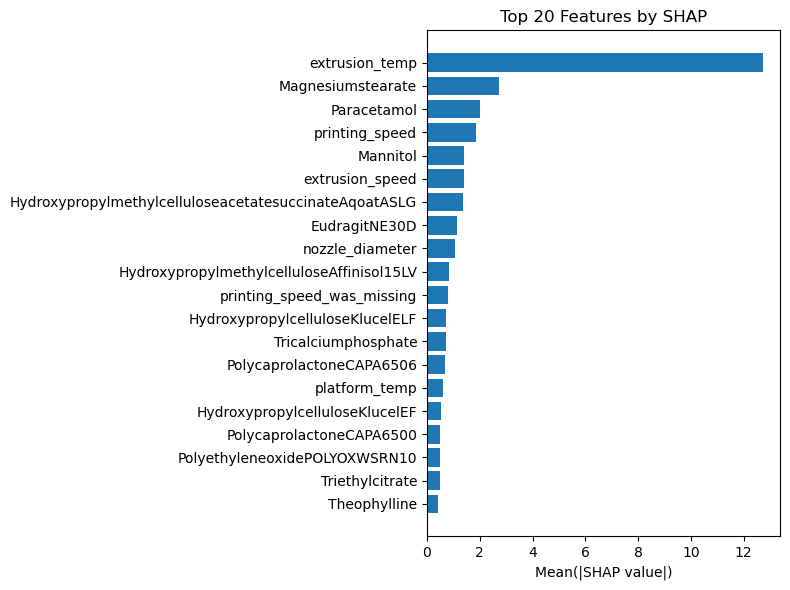

In [7]:
mean_shap = np.abs(shap_values).mean(axis=0)

shap_df = pd.DataFrame({
    'feature': X_train_filled.columns,
    'mean_abs_shap': mean_shap
}).sort_values(by='mean_abs_shap', ascending=False)

# 获取 Top70 特征名
shap_top_70 = shap_df.head(70)
shap_top_features = shap_top_70['feature'].tolist()

# 可视化 Top20 特征（倒序显示）
plt.figure(figsize=(8, 6))
plt.barh(
    shap_top_70['feature'][:20][::-1],
    shap_top_70['mean_abs_shap'][:20][::-1]
)
plt.title("Top 20 Features by SHAP")
plt.xlabel("Mean(|SHAP value|)")
plt.tight_layout()
plt.show()


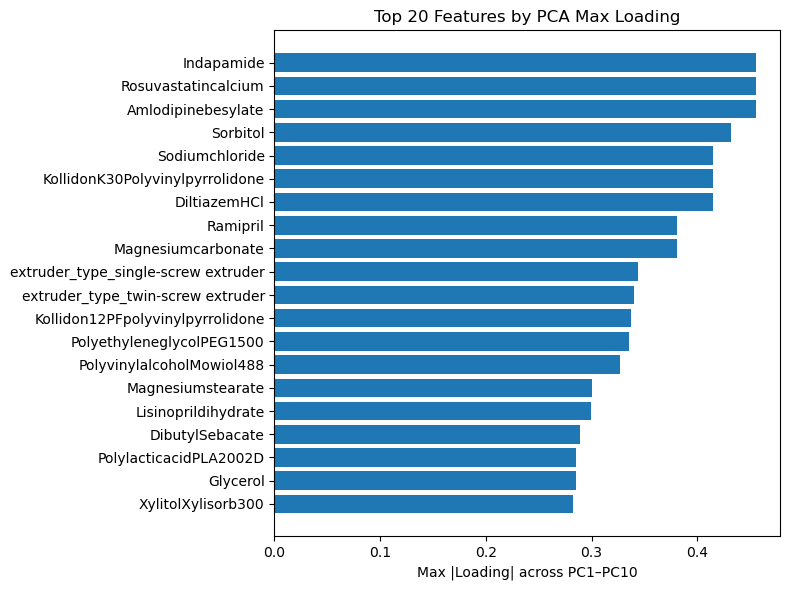

In [8]:
from sklearn.decomposition import PCA

# 设置保留主成分个数
pca = PCA(n_components=10, random_state=42)
pca.fit(X_train_filled)

# 获取每个主成分对应的所有特征 loading
loadings = np.abs(pca.components_) 

# 计算每个特征在所有主成分中的“最大 loading”
max_loading_per_feature = loadings.max(axis=0)

# 映射回特征名
pca_df = pd.DataFrame({
    'feature': cols,
    'max_loading': max_loading_per_feature
}).sort_values(by='max_loading', ascending=False)

# 取 Top 70 特征
pca_top_70 = pca_df.head(70)
pca_top_features = pca_top_70['feature'].tolist()

# 可视化 Top 20 特征的 loading 值
plt.figure(figsize=(8, 6))
plt.barh(pca_top_70['feature'][:20][::-1], pca_top_70['max_loading'][:20][::-1])
plt.title("Top 20 Features by PCA Max Loading")
plt.xlabel("Max |Loading| across PC1–PC10")
plt.tight_layout()
plt.show()


Epoch 0 - Loss: 22838.2754, Attention: μ=0.0028, σ=0.0012
Epoch 10 - Loss: 31204.3887, Attention: μ=0.0028, σ=0.0503
Epoch 20 - Loss: 26628.4648, Attention: μ=0.0028, σ=0.0502
Epoch 30 - Loss: 31071.1836, Attention: μ=0.0028, σ=0.0501
Epoch 40 - Loss: 27918.0469, Attention: μ=0.0028, σ=0.0501


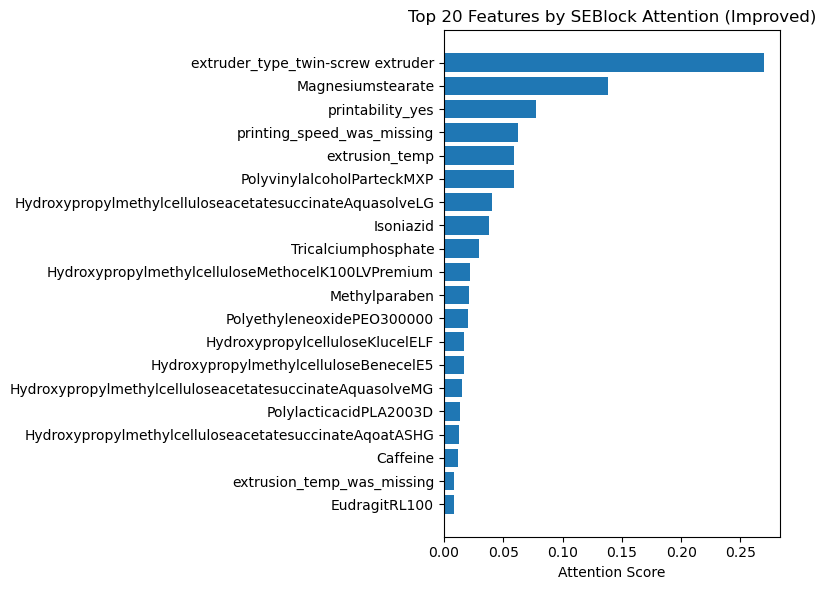

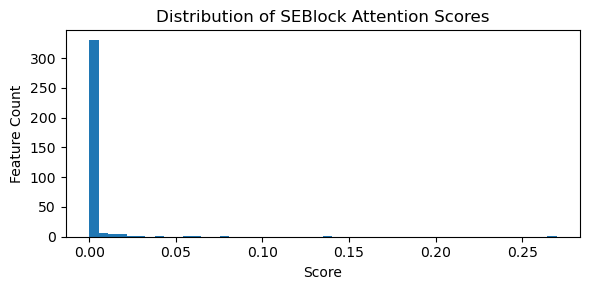

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


# 1. 转换为 PyTorch 格式
X_tensor = torch.tensor(X_train_filled.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 2. 改进版 SEBlock 模型：用 Softmax 做特征级注意力归一化
class SEBlockMLP(nn.Module):
    def __init__(self, input_dim):
        super(SEBlockMLP, self).__init__()
        self.se = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.Softmax(dim=1)  # 改成 Softmax，特征间相对权重
        )
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        weights = self.se(x)           # 注意力得分
        x_weighted = x * weights       # 加权特征输入
        out = self.classifier(x_weighted)
        return out, weights

# 3. 初始化模型
model = SEBlockMLP(X_train_filled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 训练模型
for epoch in range(50):
    for xb, yb in loader:
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            _, weights = model(X_tensor)
            mean_score = weights.mean().item()
            std_score = weights.std().item()
            print(f"Epoch {epoch} - Loss: {loss.item():.4f}, Attention: μ={mean_score:.4f}, σ={std_score:.4f}")

# 5. 提取注意力特征得分（取均值）
with torch.no_grad():
    _, final_weights = model(X_tensor)
    feature_scores = final_weights.mean(dim=0).numpy()

# 6. 构造 DataFrame
se_df = pd.DataFrame({
    'feature': cols,
    'attention_score': feature_scores
}).sort_values(by='attention_score', ascending=False)

# 7. 取 Top 70 特征
se_top_70 = se_df.head(70)
se_top_features = se_top_70['feature'].tolist()

# 排序 & 取前 20
se_top_20 = se_df.sort_values(by='attention_score', ascending=False).head(20)

# 可视化
plt.figure(figsize=(8, 6))
plt.barh(se_top_20['feature'][::-1], se_top_20['attention_score'][::-1])
plt.title("Top 20 Features by SEBlock Attention (Improved)")
plt.xlabel("Attention Score")
plt.tight_layout()
plt.show()

# 9. 可视化全部注意力分数分布（辅助判断是否有效区分）
plt.figure(figsize=(6, 3))
plt.hist(feature_scores, bins=50)
plt.title("Distribution of SEBlock Attention Scores")
plt.xlabel("Score")
plt.ylabel("Feature Count")
plt.tight_layout()
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

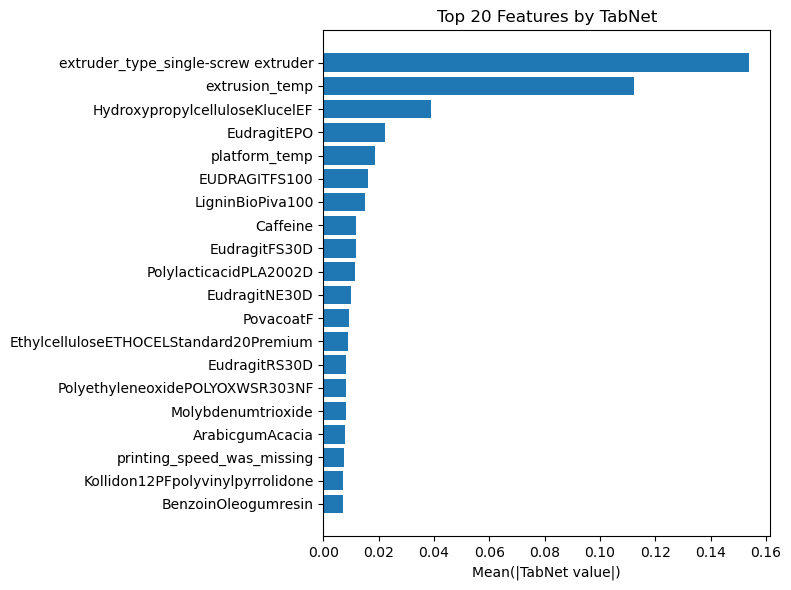

In [10]:
from pytorch_tabnet.tab_model import TabNetRegressor  

model = TabNetRegressor(seed=42)  
model.fit(
    X_train_filled.values, y_train.values.reshape(-1, 1),
    max_epochs=200,
    eval_metric='rmse'
)


importances = model.feature_importances_  # shape = (num_features,)

tabnet_feat_df = pd.DataFrame({
    'feature': cols,
    'importance': importances
}).sort_values(by='importance', ascending=False)

tabnet_top_70 = tabnet_feat_df.head(70)
tabnet_top_features = tabnet_top_70['feature'].tolist()

# 可视化 Top 20
plt.figure(figsize=(8, 6))
plt.barh(tabnet_top_70['feature'][:20][::-1], tabnet_top_70['importance'][:20][::-1])
plt.title("Top 20 Features by TabNet")
plt.xlabel("Mean(|TabNet value|)")
plt.tight_layout()
plt.show()


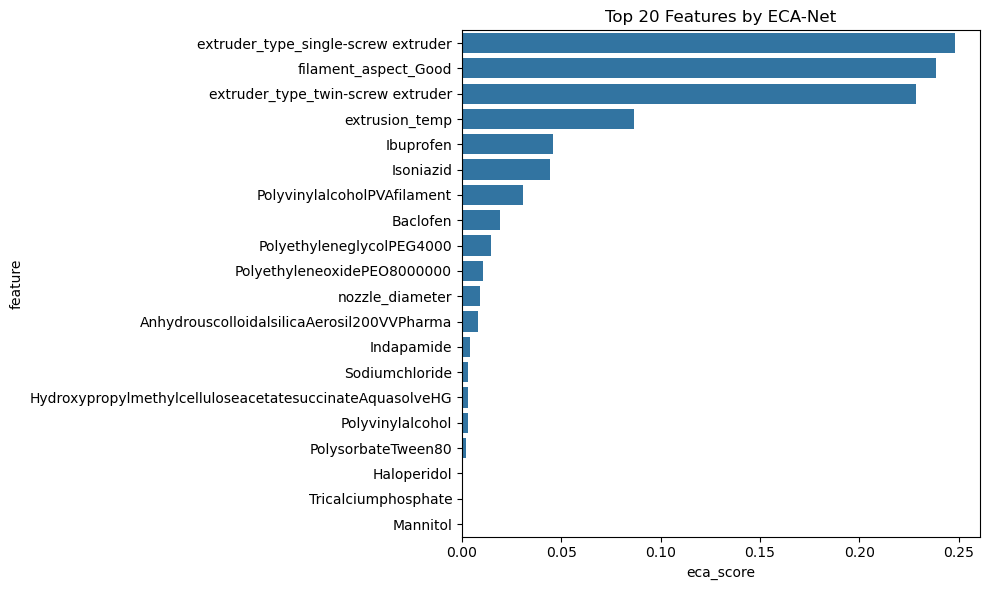

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1. 转换为 PyTorch 张量
X_tensor = torch.tensor(X_train_filled.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 2. 定义 ECA-Net 结构
class ECABlockMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.se = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.Softmax(dim=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        weights = self.se(x)
        x_weighted = x * weights
        out = self.classifier(x_weighted)
        return out, weights

# 3. 初始化模型
model = ECABlockMLP(X_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 训练模型
for epoch in range(50):
    for xb, yb in loader:
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 5. 提取特征权重
with torch.no_grad():
    _, weights = model(X_tensor)
    attention_score = weights.mean(dim=0).numpy()

# 6. 保存成 DataFrame
eca_df = pd.DataFrame({
    'feature': cols,
    'eca_score': attention_score
}).sort_values(by='eca_score', ascending=False)

# 7. 取 Top 70 特征名列表
eca_top_70 = eca_df.head(70)
eca_top_features = eca_top_70['feature'].tolist()

# 8. 可视化 Top 20
plt.figure(figsize=(10, 6))
sns.barplot(y='feature', x='eca_score', data=eca_top_70.head(20))
plt.title("Top 20 Features by ECA-Net")
plt.tight_layout()
plt.show()


出现在 ≥2 个方法中的特征数：101
[0]	train-rmse:30.90379	test-rmse:29.75594
[1]	train-rmse:29.08090	test-rmse:28.19533
[2]	train-rmse:27.43254	test-rmse:26.91884
[3]	train-rmse:26.07161	test-rmse:25.75334
[4]	train-rmse:24.87345	test-rmse:24.82595
[5]	train-rmse:23.56776	test-rmse:23.47712
[6]	train-rmse:22.51314	test-rmse:22.48872
[7]	train-rmse:21.39375	test-rmse:21.42242
[8]	train-rmse:20.37367	test-rmse:20.36475
[9]	train-rmse:19.52933	test-rmse:19.53300
[10]	train-rmse:18.66622	test-rmse:18.79989
[11]	train-rmse:18.21507	test-rmse:18.47448
[12]	train-rmse:17.85464	test-rmse:18.23621
[13]	train-rmse:17.15245	test-rmse:17.77123
[14]	train-rmse:16.61747	test-rmse:17.36052
[15]	train-rmse:15.95517	test-rmse:16.76982
[16]	train-rmse:15.58918	test-rmse:16.42429
[17]	train-rmse:15.12118	test-rmse:16.08466
[18]	train-rmse:14.77529	test-rmse:15.82298
[19]	train-rmse:14.39008	test-rmse:15.52766
[20]	train-rmse:14.14934	test-rmse:15.33726
[21]	train-rmse:13.87275	test-rmse:15.18489
[22]	train-rmse:13.464

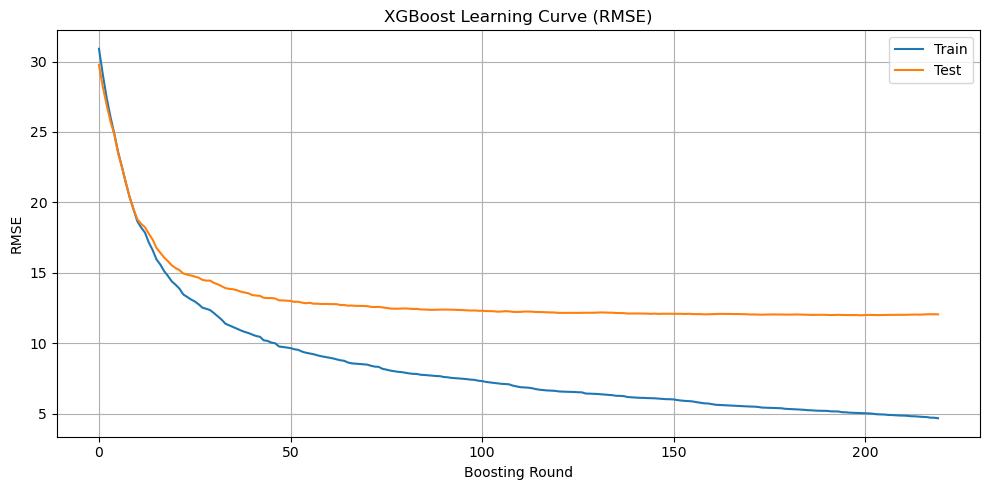

In [12]:
from collections import Counter
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


# 构造“出现次数≥2”的特征子集
all_top_features = shap_top_features + pca_top_features + se_top_features + tabnet_top_features + eca_top_features
feature_counter = Counter(all_top_features)

# 筛选出现 ≥2 次的特征
selected_features = [feat for feat, count in feature_counter.items() if count >= 2]
print(f"出现在 ≥2 个方法中的特征数：{len(selected_features)}")


# 1. 特征选择 + 标准化
X_selected = X_train_filled[selected_features]
X_selected_scaled = scaler.fit_transform(X_selected)

X_test_selected = X_test_filled[selected_features]
X_test_scaled = scaler.transform(X_test_selected)

# 2. 转换为 DMatrix
dtrain = xgb.DMatrix(X_selected_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# 3. 参数设置
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# 4. 训练模型
# 先创建 eval_result 字典来接收评估信息
eval_result = {}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=300,
    early_stopping_rounds=20,
    evals=[(dtrain, "train"), (dtest, "test")], 
    evals_result=eval_result, 
    verbose_eval=True
)

# 5. 预测 + 评估
y_pred = model.predict(dtest)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Final Test R²: {r2:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")
print(f"Final Test MAE: {mae:.4f}")



# 8. 可视化学习曲线
epochs = len(eval_result['train']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, eval_result['train']['rmse'], label='Train')
plt.plot(x_axis, eval_result['test']['rmse'], label='Test')
plt.title('XGBoost Learning Curve (RMSE)')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



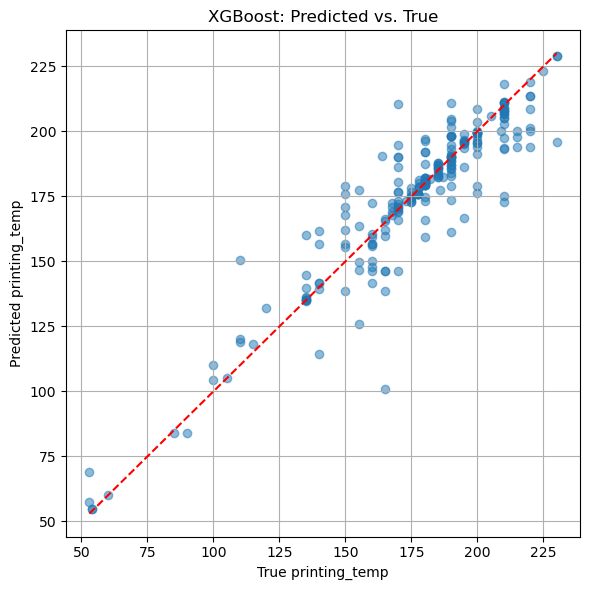

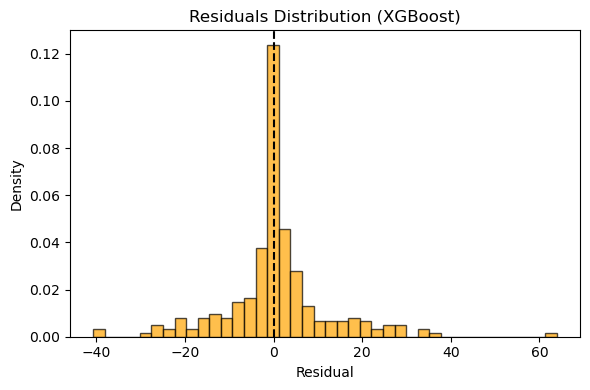

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True printing_temp")
plt.ylabel("Predicted printing_temp")
plt.title("XGBoost: Predicted vs. True")
plt.grid(True)
plt.tight_layout()
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, color='orange', edgecolor='black', alpha=0.7, density=True)
plt.title("Residuals Distribution (XGBoost)")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packag

              Model        R2       RMSE        MAE
4          CatBoost  0.829457  13.426149   8.601375
2      RandomForest  0.822999  13.614711   7.618730
1      XGB_Train 原生  0.816734  13.883939   8.339873
0      XGBRegressor  0.803022  14.407389   8.505227
8           HistGBR  0.777044  15.321931   9.598974
5              LGBM  0.760171  15.911034  10.590985
9               KNN  0.702659  17.884981  10.474720
7               MLP  0.691935  17.901937  10.113434
6               SVR  0.667017  18.895343  10.103713
3  LinearRegression  0.660679  18.877097  12.603393


C:\Users\PC\AppData\Local\Temp\ipykernel_21036\541603914.py:99: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_21036\541603914.py:99: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


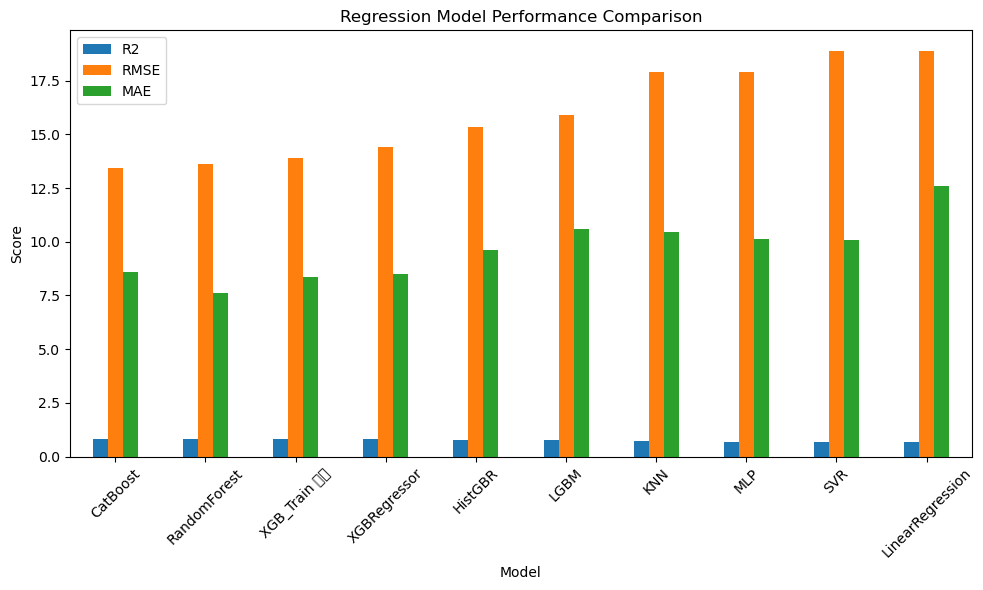

In [14]:
from sklearn.base import BaseEstimator, RegressorMixin
import xgboost as xgb

class XGBTrainWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, params=None, num_boost_round=300, early_stopping_rounds=20, verbose_eval=False):
        self.params = params or {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'eta': 0.05,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'seed': 42
        }
        self.num_boost_round = num_boost_round
        self.early_stopping_rounds = early_stopping_rounds
        self.verbose_eval = verbose_eval
        self.model = None

    def fit(self, X, y):
        dtrain = xgb.DMatrix(X, label=y)
        self.model = xgb.train(
            self.params,
            dtrain,
            num_boost_round=self.num_boost_round,
            verbose_eval=self.verbose_eval
        )
        return self

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return self.model.predict(dtest)

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 自定义评分器
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)  

# 交叉验证
cv = KFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

models = {
    'XGBRegressor': XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42),
    'XGB_Train 原生': XGBTrainWrapper(),  
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression(),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LGBM': LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, verbose=-1, random_state=42),
    'SVR': SVR(kernel='rbf', C=100, gamma=0.1),
    'MLP': MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=42),
    'HistGBR': HistGradientBoostingRegressor(random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}


# 结果收集
results = []

for name, model in models.items():
    r2 = cross_val_score(model, X_selected_scaled, y_train, cv=cv, scoring='r2').mean()
    neg_rmse = cross_val_score(model, X_selected_scaled, y_train, cv=cv, scoring=rmse_scorer).mean()
    mae = cross_val_score(model, X_selected_scaled, y_train, cv=cv, scoring='neg_mean_absolute_error').mean()

    results.append({
        'Model': name,
        'R2': r2,
        'RMSE': -neg_rmse,
        'MAE': -mae
    })

# 结果表格
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='R2', ascending=False)
print(df_results)

# 可视化
df_results.set_index('Model')[['R2', 'RMSE', 'MAE']].plot(kind='bar', figsize=(10,6))
plt.title("Regression Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [15]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
import joblib
# 参数空间
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [300, 500, 800],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 64, 128]
}

# 定义模型
cat = CatBoostRegressor(
    verbose=0, 
    loss_function='RMSE',
    random_state=42
)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,
    scoring='r2', 
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 开始搜索
random_search.fit(X_selected_scaled, y_train)
best_catboost = random_search.best_estimator_
best_params = random_search.best_params_

# 输出最优参数和分数
print("最佳参数：", random_search.best_params_)
print("最佳 R² 分数：", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
最佳参数： {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 8, 'border_count': 64, 'bagging_temperature': 0}
最佳 R² 分数： 0.842314260846797


In [16]:
import joblib

# 组织为字典（如果需要也可以添加其他信息）
model_package = {
    'model': best_catboost,
    'best_params': best_params
}

# 保存模型
joblib.dump(model_package, 'best_catboost_regressor.pkl')



['best_catboost_regressor.pkl']

In [17]:
!pip install -U scikit-learn
